### Spectrograms, mel scaling, and Inversion demo in jupyter/ipython
This is just a bit of code that shows you how to make a spectrogram/sonogram in python using numpy, scipy, and a few functions written by <a href="https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe">Kyle Kastner</a>. I also show you how to invert those spectrograms back into wavform, filter those spectrograms to be mel-scaled, and invert those spectrograms as well. This should prove to be a useful tool for those interested in generative modelling (as I am). For example, running spectrograms through an LSTM, VAE, GAN, <a href="https://timsainb.github.io/multi-gpu-vae-gan-in-tensorflow.html">VAE-GAN</a>, or experimenting with your own audio/waveform models. Check out the <a href="http://www.openslr.org/12/">LibriSpeech dataset.</a> for a 1000 hr dataset of transcripted speech from open source audio books. 

In [1]:
# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

### Make Spectrogram
(Skip over this for now and take a look at the output below)

In [2]:
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

def freq_to_mel(f):
    return 2595.*np.log10(1+(f/700.))
def mel_to_freq(m):
    return 700.0*(10.0**(m/2595.0)-1.0)

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    spec_size = fft_size/2
    start_mel = freq_to_mel(start_freq)
    end_mel = freq_to_mel(end_freq)
    plt_spacing = []
    # find our central channels from the spectrogram
    for i in range(10000):
        y = np.linspace(start_mel, end_mel, num=i, endpoint=False)
        logp = mel_to_freq(y)
        logp = logp/(rate/2/spec_size)
        true_spacing = [int(i)-1 for i in np.ceil(logp)] 
        plt_spacing_mel = np.unique(true_spacing)
        if len(plt_spacing_mel) == n_freq_components:
            break
    plt_spacing = plt_spacing_mel
    if plt_spacing_mel[-1] == spec_size:
        plt_spacing_mel[-1] = plt_spacing_mel[-1]-1
    # make the filter
    mel_filter = np.zeros((int(spec_size),n_freq_components))
    # Create Filter
    for i in range(len(plt_spacing)):  
        if i > 0:
            if plt_spacing[i-1] < plt_spacing[i] - 1:
                # the first half of the window should start with zero
                mel_filter[plt_spacing[i-1]:plt_spacing[i], i] = np.arange(0,1,1./(plt_spacing[i]-plt_spacing[i-1]))
        if i < n_freq_components-1:
            if plt_spacing[i+1] > plt_spacing[i]+1:
                mel_filter[plt_spacing[i]:plt_spacing[i+1], i] = np.arange(0,1,1./(plt_spacing[i+1]-plt_spacing[i]))[::-1]
        elif plt_spacing[i] < spec_size:
            mel_filter[plt_spacing[i]:int(mel_to_freq(end_mel)/(rate/2/spec_size)), i] =  \
                np.arange(0,1,1./(int(mel_to_freq(end_mel)/(rate/2/spec_size))-plt_spacing[i]))[::-1]
        mel_filter[plt_spacing[i], i] = 1
    # Normalize filter
    mel_filter = mel_filter / mel_filter.sum(axis=0)
    # Create and normalize inversion filter
    mel_inversion_filter = np.transpose(mel_filter) / np.transpose(mel_filter).sum(axis=0)
    mel_inversion_filter[np.isnan(mel_inversion_filter)] = 0 # for when a row has a sum of 0

    return mel_filter, mel_inversion_filter

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec


### Parameters

In [3]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 

### Loading the WAV

In [4]:
# Grab your wav and filter it
mywav = 'bushOffersPeace.wav'
rate, data = wavfile.read(mywav)
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10] 
print 'Length in time (s): ', np.shape(data)[0]/float(rate)

Length in time (s):  4.54743764172


In [5]:
# Play the audio
IPython.display.Audio(data=data, rate=rate)

### Making the spectrogram

In [6]:
wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

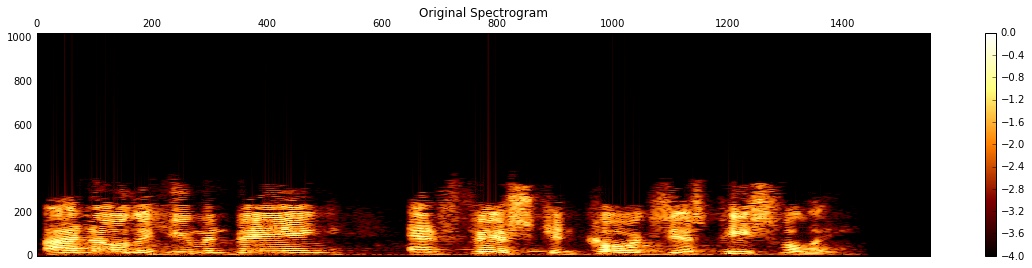

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

### Inverting the Spectrogram

In [8]:
# Invert from the spectrogram back to a waveform
recovered_audio_orig = invert_pretty_spectrogram(wav_spectrogram, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=recovered_audio_orig, rate=rate) # play the audio

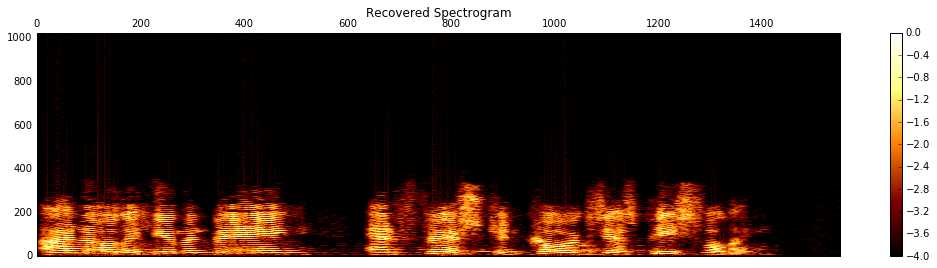

In [9]:
# Make a spectrogram of the inverted audio (for visualization)
inverted_spectrogram = pretty_spectrogram(recovered_audio_orig.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
cax = ax.matshow(np.transpose(inverted_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Recovered Spectrogram')

### Mel Compression

In [10]:
# Generate the mel filters
mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)

/local/home/tsainbur/.conda/envs/tim_tf/lib/python2.7/site-packages/ipykernel/__main__.py:268: RuntimeWarning: invalid value encountered in divide


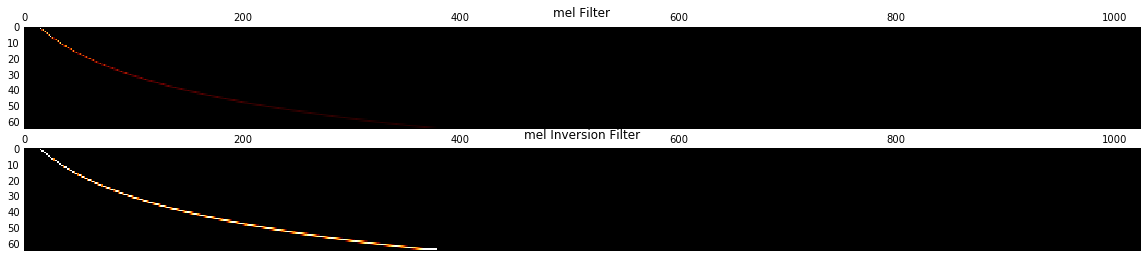

In [11]:
# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

In [12]:
mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)

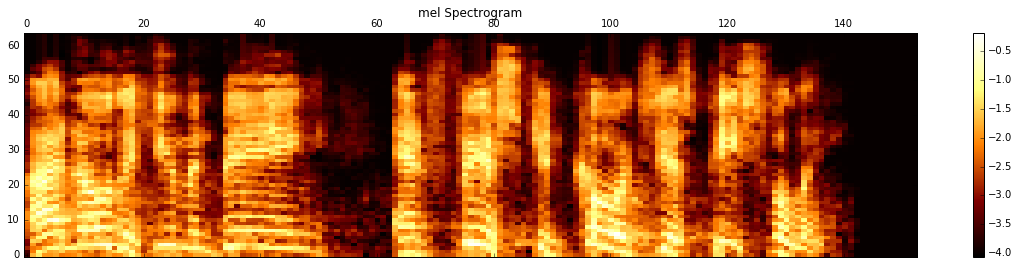

In [13]:
# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))

cax = ax.matshow(mel_spec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('mel Spectrogram')

In [14]:
# Output some stats of our file
print ''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))])
print ''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))])
print ''.join(['Original Waveform Size: ',str(np.shape(data))])
print ''.join(['Length (s): ', str(len(data)/float(rate))])
print ''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))])
print ''.join(['New Sampling Rate (ms): ', str(float(np.shape(mel_spec)[1]) / (len(data)/float(rate)))])

mel Spectrogram Size: (64, 153)
Original Spectrogram Size: (1024, 1552)
Original Waveform Size: (200542,)
Length (s): 4.54743764172
Original Sampling Rate (ms) : 2.26757369615e-05
New Sampling Rate (ms): 33.6453211796


In [15]:
mel_inverted_spectrogram = mel_to_spectrogram(mel_spec, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

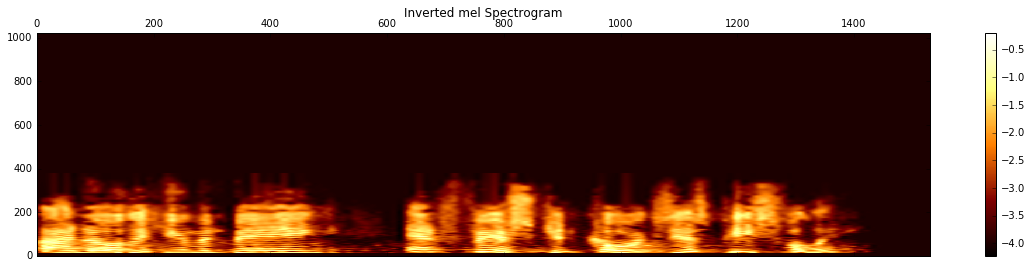

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(mel_inverted_spectrogram, cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')

In [ ]:
inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

### Sources:
- Audio tools by KastnerKyle
  - https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

In [ ]:
!jupyter nbconvert --to markdown Python-Spectrograms-MFCC-and-Inversion.ipynb
!jupyter nbconvert --to HTML Python-Spectrograms-MFCC-and-Inversion.ipynb

!cp Python-Spectrograms-MFCC-and-Inversion.md readme.md